In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load dataset
data_path = r'Dataset_14-day_AA_depression_symptoms_mood_and_PHQ-9.csv'
df = pd.read_csv(data_path)
df.columns = df.columns.str.strip()

# Calculate PHQ-9 total
phq_columns = ['phq1','phq2','phq3','phq4','phq5','phq6','phq7','phq8','phq9']
df['phq_total'] = df[phq_columns].sum(axis=1)

# Target variable
df['has_mental_health_issues'] = (df['phq_total'] >= 10).astype(int)

# Encode categorical
df['sex'] = df['sex'].map({'male':0,'female':1})

# Features
feature_columns = phq_columns + ['age','sex']
X = df[feature_columns]
y = df['has_mental_health_issues']

# Preprocessing
numeric_features = phq_columns + ['age']
categorical_features = ['sex']

numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer([
    ('num', numeric_imputer, numeric_features),
    ('cat', categorical_imputer, categorical_features)
])

X_imputed = preprocessor.fit_transform(X)
X_imputed[:,:len(numeric_features)] = X_imputed[:,:len(numeric_features)].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split & resample
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train,y_train)

# Train SVM
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_resampled,y_resampled)

# Cross-validation
scores = cross_val_score(svm_model,X_resampled,y_resampled,cv=5,scoring='accuracy')
print("SVM CV Scores:",scores)
print("SVM Mean CV Accuracy:",scores.mean())

# Evaluation
y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:,1]
print("SVM ROC-AUC:", roc_auc_score(y_test,y_proba))
print("SVM Report:\n", classification_report(y_test,y_pred))

SVM CV Scores: [1.         0.99801587 1.         1.         1.        ]
SVM Mean CV Accuracy: 0.9996031746031747
SVM ROC-AUC: 1.0
SVM Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1106
           1       1.00      1.00      1.00      3739

    accuracy                           1.00      4845
   macro avg       1.00      1.00      1.00      4845
weighted avg       1.00      1.00      1.00      4845



In [2]:
import shap 
shap.initjs()

background = shap.sample(X_train, 3)

explainer = shap.KernelExplainer(svm_model.predict_proba, background)
shap_values = explainer(X_test)

C:\Users\kumud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4845/4845 [03:50<00:00, 21.02it/s]


In [3]:
np.shape(shap_values)

(4845, 11, 2)

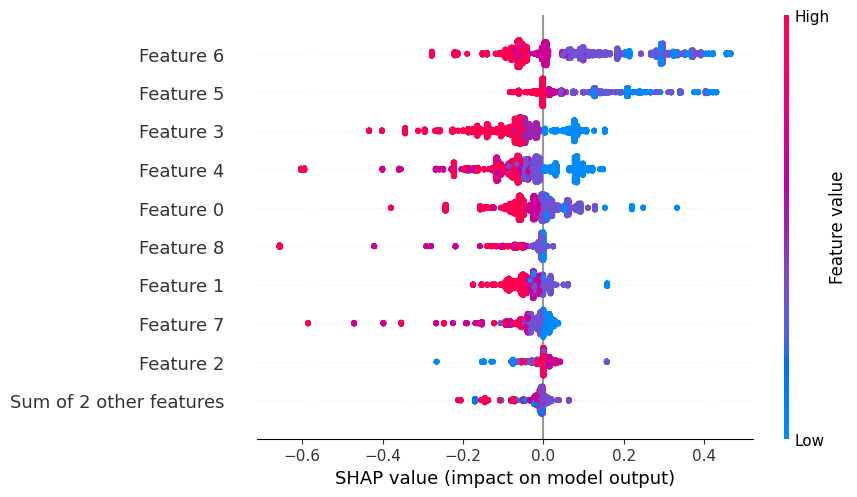

In [7]:
shap.plots.beeswarm(shap_values[:4845,:,0])

In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report

# Load dataset
file_path = r"cleaned_anxiety_dataset.csv"
df = pd.read_csv(file_path)

# Drop 'id' column if it exists
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Compute GAD-7 score
gad_columns = ['gad1','gad2','gad3','gad4','gad5','gad6','gad7']
df['gad7_total'] = df[gad_columns].sum(axis=1)

# Binary anxiety label
df['anxiety_label'] = (df['gad7_total'] >= 10).astype(int)

# Encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df[gad_columns])
y = df['anxiety_label']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Train SVM
model = SVC(probability=True, random_state=42)
model.fit(X_train,y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("SVM CV Accuracy Scores:", cv_scores)
print("SVM Mean CV Accuracy:", cv_scores.mean())

# Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
print("SVM ROC-AUC:", roc_auc_score(y_test,y_proba))
print("SVM Report:\n", classification_report(y_test,y_pred))


SVM CV Accuracy Scores: [0.98387097 0.97580645 0.99193548 1.         0.98387097]
SVM Mean CV Accuracy: 0.9870967741935484
SVM ROC-AUC: 0.9988849241748439
SVM Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           1       0.95      0.97      0.96        38

    accuracy                           0.98       156
   macro avg       0.97      0.98      0.97       156
weighted avg       0.98      0.98      0.98       156



In [14]:
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values1 = explainer(X_test)

np.shape(shap_values1)

Using 620 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 156/156 [00:58<00:00,  2.67it/s]


(156, 7, 2)

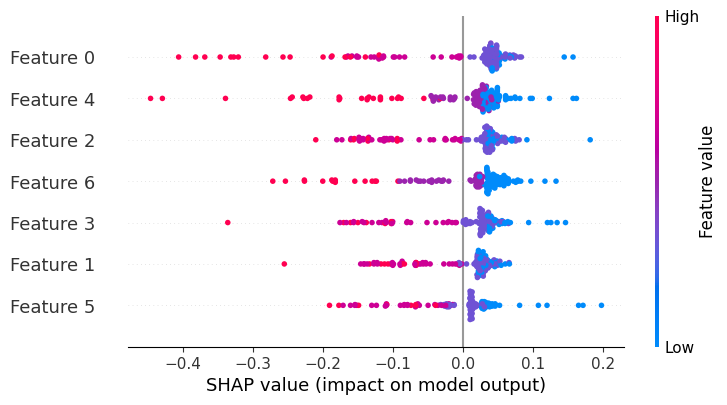

In [15]:
shap.plots.beeswarm(shap_values1[:156,:,0])